<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Visualizing Survey Property Maps</b> <br>
Contact author(s): Eli Rykoff <br>
Last verified to run: 2022-07-24 <br>
LSST Science Piplines version: Weekly 2022_22 <br>
Container Size: large <br>
Targeted learning level: intermediate <br>

In [1]:
### DO NOT DELETE UNTIL THIS HAS BEEN RUN ON NB

# %load_ext pycodestyle_magic
# %flake8_on
# import logging
# logging.getLogger("flake8").setLevel(logging.FATAL)

**Description:** Demonstrate tools to visualize survey property maps.

**Skills:** Load and visualize survey property maps using healsparse and skyproj.

**LSST Data Products:** Survey property maps.

**Packages:** healsparse, skyproj, lsst.daf.butler

**Credit:**
This notebook was originally developed by Eli Rykoff with editing from Alex Drlica-Wagner.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook will teach the user how to load and visualize survey property maps generated by the Rubin Science Pipelines. Data products are accessed through the Butler, and the user is expected to be familiar with the content of the introductory Butler tutorial. It introduces two new packages, `healsparse` and `skyproj`, for working with survey property maps.

### 1.1 Package Imports

Import general python packages and the Butler from the science pipelines.

Import two additional packages for working with the survey property maps.

The `healsparse` packages provides utilities for reading and manipulating sparse healpix maps.
More information can be found in the documentation "[HealSparse: A sparse implementation of HEALPix](https://healsparse.readthedocs.io/en/latest/)".

The `skyproj` package provides utilities for visualizing both sparse and dense HEALPix maps, as described in the documentation "[SkyProj: Sky Projections with matplotlib and PROJ](https://skyproj.readthedocs.io/en/latest/)".

> **Notice:** The following cell will output a warning about a version mismatch between CFITSIO and a linked library when used with version Weekly 2022_22. This warning can be safely ignored and will be corrected in the future.

In [2]:
# general python packages
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval, LinearStretch, ImageNormalize

# default plot style is accessible
plt.style.use('tableau-colorblind10')

# packages for working with sparse healpix maps
import healsparse as hsp
import skyproj

# LSST packages
from lsst.daf.butler import Butler
import lsst.geom as geom

# allow interactive plots
%matplotlib widget

## 2. Access Survey Property Maps

Survey property maps are created as part of the LSST Science Pipelines.
They take the form of sparse HEALPix maps, where the survey property at each spatial pixel is identified by a pixel number/pixel value pair.

Start by creating an instance of the Butler and using it to access these maps for DP0.

In [3]:
config = 'dp02'
collections = '2.2i/runs/DP0.2'
butler = Butler(config, collections=collections)

Determine which property maps are available for the survey.

> **Notice:** The following cell produces a warning about the 'ScarletModelData' storage class, which is safe to ignore.

In [4]:
for dtype in sorted(butler.registry.queryDatasetTypes(expression="*consolidated_map*")):
    print(dtype.name)

deepCoadd_dcr_ddec_consolidated_map_weighted_mean
deepCoadd_dcr_dra_consolidated_map_weighted_mean
deepCoadd_dcr_e1_consolidated_map_weighted_mean
deepCoadd_dcr_e2_consolidated_map_weighted_mean
deepCoadd_exposure_time_consolidated_map_sum
deepCoadd_psf_e1_consolidated_map_weighted_mean
deepCoadd_psf_e2_consolidated_map_weighted_mean
deepCoadd_psf_maglim_consolidated_map_weighted_mean
deepCoadd_psf_size_consolidated_map_weighted_mean
deepCoadd_sky_background_consolidated_map_weighted_mean
deepCoadd_sky_noise_consolidated_map_weighted_mean


Each of these products represents a healsparse map containing the value of an individual survey property.

The meaning of these types is:

* `deepCoadd_dcr_ddec_consolidated_map_weighted_mean`: Average effect of differential chromatic refraction (DCR) in declination direction
* `deepCoadd_dcr_dra_consolidated_map_weighted_mean`: Average effect of differential chromatic refraction (DCR) in right ascension direction
* `deepCoadd_dcr_e1_consolidated_map_weighted_mean`: Average effect of differential chromatic refraction (DCR) on psf e1
* `deepCoadd_dcr_e2_consolidated_map_weighted_mean`: Average effect of differential chromatic refraction (DCR) on psf e2
* `deepCoadd_exposure_time_consolidated_map_sum`: Total exposure time (seconds)
* `deepCoadd_psf_e1_consolidated_map_weighted_mean`: Weighted mean of psf e1 of images input to coadd
* `deepCoadd_psf_e2_consolidated_map_weighted_mean`: Weighted mean of psf e2 of images input to coadd
* `deepCoadd_psf_maglim_consolidated_map_weighted_mean`: PSF Flux 5-sigma magnitude limit (AB)
* `deepCoadd_psf_size_consolidated_map_weighted_mean`: Weighted mean of psf size of images input to coadd (pixels)
* `deepCoadd_sky_background_consolidated_map_weighted_mean`: Weighted mean of sky background of images input to coadd (ADU)
* `deepCoadd_sky_noise_consolidated_map_weighted_mean`: Weighted mean of sky noise of images input to coadd (ADU)


Note that the DCR maps are proportionality maps; that is, the expected effect will be proportional to the value in the map with an arbitrary/empirically derived constant of proportionality.

Read a map by specifying the map name and a band.

In [5]:
hspmap = butler.get('deepCoadd_psf_maglim_consolidated_map_weighted_mean', band='i')

## 3. Manipulating Survey Property Maps

The survey property maps are provided as healsparse objects.

We provide a few very brief examples here.

To conserve memory, HealSparse uses a dual-map approach, where a low-resolution full-sky “coverage map” is combined with a high resolution map containing the pixel data where it is available. It is easy to find teh resolution of these maps.

In [6]:
print(hspmap)

HealSparseMap: nside_coverage = 32, nside_sparse = 32768, float64


Each pixel of the healsparse map corresponds to a small region of the sky.
The value of the map corresponds to the value of the survey property at that location.

To access the survey property value at a specific location or set of locations, query for the map value using the `get_values_pos` functionality.

In [7]:
print(hspmap.get_values_pos(60, -37))

26.270545136549963


Query for the map value at an array of locations.

In [8]:
ra = np.linspace(59.5, 60.5, 5)
print('RA: ',ra)
dec = np.linspace(-37.5, -36.5, 5)
print('Dec: ', dec)
for d in dec:
    print(hspmap.get_values_pos(ra, d))
del ra, dec

RA:  [59.5  59.75 60.   60.25 60.5 ]
Dec:  [-37.5  -37.25 -37.   -36.75 -36.5 ]
[26.34471307 26.27623167 26.24152062 26.25072875 26.21620769]
[26.30356777 26.30608976 26.29560979 26.28747846 26.17711634]
[26.28514358 26.29065708 26.27054514 26.27091482 26.26656088]
[26.26560554 26.29529376 26.24400561 26.21773684 26.20629068]
[26.30158836 26.27697892 26.2329668  26.18495793 26.19455988]


If you ask for the value of the map outside of the region where it is defined, you will get a sentinel value.

In [9]:
print(hspmap.get_values_pos(180, 0))

-1.6375e+30


## 4. Visualizing Survey Property Maps

Now that we know how to access the values of the healsparse map, we can put together our own simple visualization by creating a grid of RA, Dec values and asking for the map values.
We can then plot these values with matplotlib.
Note that if you pan or zoom, the map does not update in resolution or coverage area.

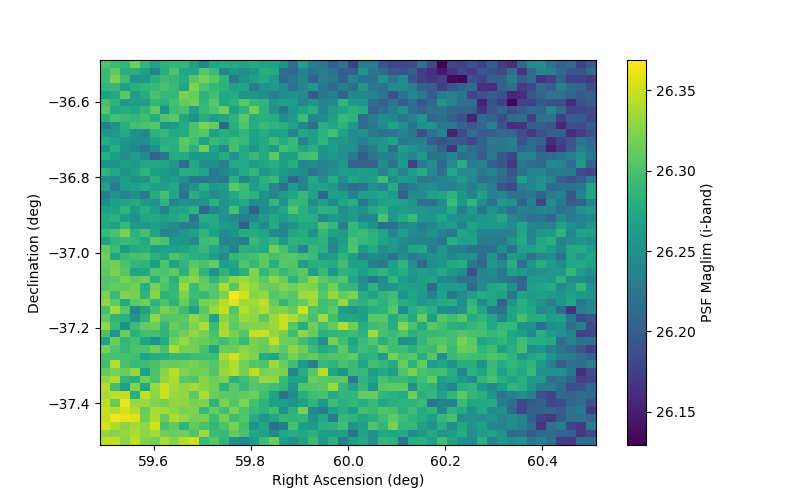

In [10]:
ra = np.linspace(59.5,60.5, 50)
dec = np.linspace(-37.5,-36.5, 50)
x,y = np.meshgrid(ra,dec)
values = hspmap.get_values_pos(x,y)

fig = plt.figure(figsize=(8, 5))
plt.pcolormesh(x, y, values)
plt.xlabel("Right Ascension (deg)")
plt.ylabel("Declination (deg)")
plt.colorbar(label="PSF Maglim (i-band)")
plt.show()

del fig, ra, dec, x, y, values

The `skyproj` package provides much more advanced plotting capabilities.
Here we will demonstrate some basic use-cases for dealing with survey property maps.

The use of `McBrydeSkyproj` with `lon_0=65.0` creates a visualization using the McBryde-Thomas Flat Polar Quartic, centered at 65 deg longitude, appropriate for the DP0.2 footprint

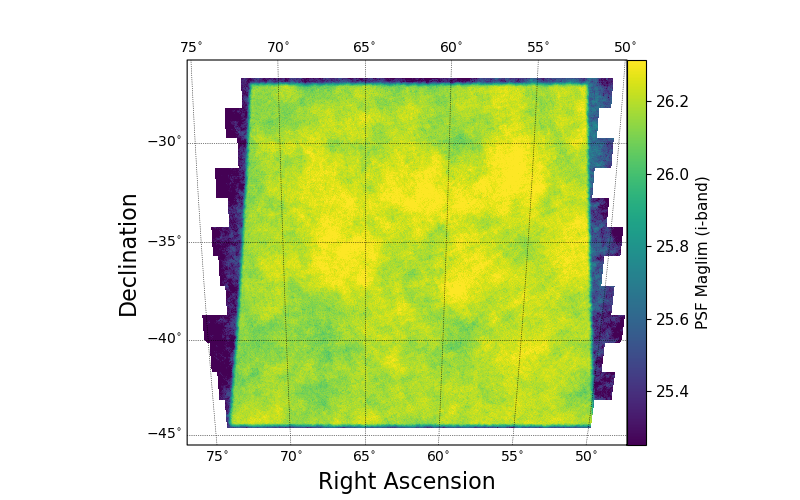

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))
sp = skyproj.McBrydeSkyproj(ax=ax, lon_0=65.0)
sp.draw_hspmap(hspmap)
sp.draw_colorbar(label='PSF Maglim (i-band)')
plt.show()

del fig, ax, sp

Notice that the edges of the survey are pulling the color scale and making it hard to see variations in the main survey area. We can create another visualization with a new colormap range to emphasize these smaller veriations.


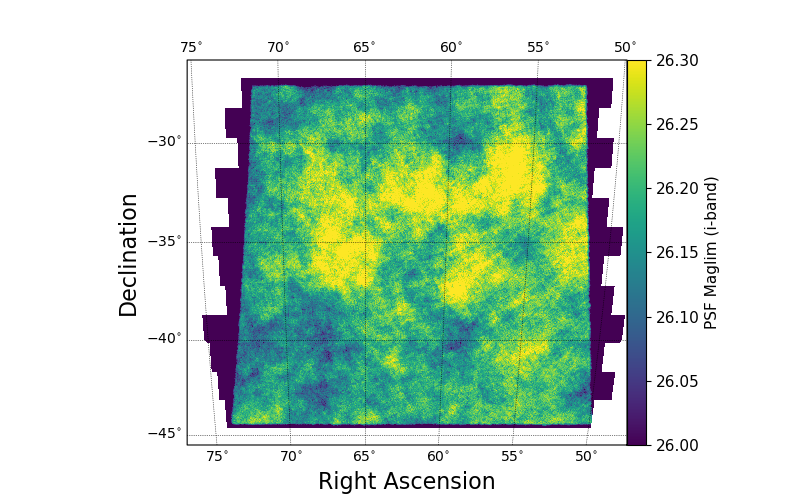

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))
sp = skyproj.McBrydeSkyproj(ax=ax, lon_0=65.0)
sp.draw_hspmap(hspmap, vmin=26.0, vmax=26.3)
sp.draw_colorbar(label='PSF Maglim (i-band)')
plt.show()

del fig, ax, sp

The above maps are interactive thanks to our use of `%matplotlib widget` at the beginning of the notebook.  You can use the matplotlib "Zoom to rectangle" tool to draw a box and zoom in.  As you move the mouse around the map, the bottom label will show the longitude, latitude, and map value.  When you zoom in the default is that the colorbar will autoscale according to the data in the box.  If you want to turn this off you can specify `sp.set_autorescale(False)`

You can also zoom on a specific longitude/latitude range, as shown below, with the vmin/vmax changed to make it look better.

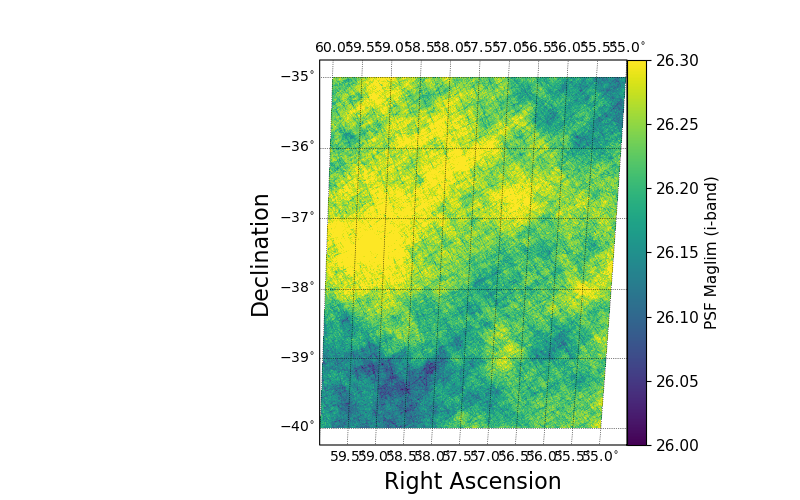

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))
sp = skyproj.McBrydeSkyproj(ax=ax, lon_0=65.0)
sp.draw_hspmap(hspmap, vmin=26.0, vmax=26.3, lon_range=[55, 60], lat_range=[-40, -35])
sp.draw_colorbar(label='PSF Maglim (i-band)')
plt.show()

del fig, ax, sp

## 5. Visualizing multiple maps, side-by-side with a deepCoadd image

Create a 2x2 grid with the deeply coadded image alongside maps of the the magnitude limit, PSF size, and sky background.

### 5.1. Retrieve an i-band deepCoadd

In [14]:
ra_deg  = 55.745834
dec_deg = -32.269167
spherePoint = geom.SpherePoint(ra_deg*geom.degrees, dec_deg*geom.degrees)
skymap = butler.get('skyMap')

In [15]:
tract = skymap.findTract(spherePoint)
patch = tract.findPatch(spherePoint)
tract = tract.tract_id
patch = patch.getSequentialIndex()

In [16]:
dataId = {'band': 'i', 'tract': tract, 'patch': patch}
deepCoadd = butler.get('deepCoadd', dataId=dataId)

Use the properties of the deepCoadd to obtain the WCS (world coordinate system), the bounding box, and the corners.

In [17]:
deepCoadd_wcs = deepCoadd.wcs
deepCoadd_bbox = deepCoadd.getBBox()

In [18]:
deepCoadd_extent = (deepCoadd.getBBox().beginX, deepCoadd.getBBox().endX,
                    deepCoadd.getBBox().beginY, deepCoadd.getBBox().endY)

In [19]:
corners = [deepCoadd_wcs.pixelToSky(deepCoadd_bbox.beginX, deepCoadd_bbox.beginY),
           deepCoadd_wcs.pixelToSky(deepCoadd_bbox.beginX, deepCoadd_bbox.endY),
           deepCoadd_wcs.pixelToSky(deepCoadd_bbox.endX, deepCoadd_bbox.endY),
           deepCoadd_wcs.pixelToSky(deepCoadd_bbox.endX, deepCoadd_bbox.beginY)]

Option to display the deepCoadd on its own.

In [20]:
# temp = deepCoadd.image.array.flatten()
# norm = ImageNormalize(temp, interval=ZScaleInterval(), stretch=LinearStretch())

# fig = plt.figure()
# plt.subplot(projection=WCS(deepCoadd.getWcs().getFitsMetadata()))
# im = plt.imshow(deepCoadd.image.array, cmap='gray', norm=norm,
#                 extent=deepCoadd_extent, origin='lower')
# plt.grid(color='white', ls='solid')
# plt.xlabel('Right Ascension')
# plt.ylabel('Declination')
# plt.show()

# del fig, im, temp, norm

### 5.2. Retrieve the PSF size and sky background survey property maps for the i-band

In [21]:
hspmap_psf = butler.get('deepCoadd_psf_size_consolidated_map_weighted_mean', band='i')

In [22]:
hspmap_sky = butler.get('deepCoadd_sky_background_consolidated_map_weighted_mean', band='i')

Define the linear space to use for the grid of survey property map data, which matches the extent of the deepCoadd.

In [23]:
for corner in corners:
    print('%6.3f %5.2f' % (corner.getRa().asDegrees(), corner.getDec().asDegrees()))

55.790 -32.32
55.790 -32.09
55.514 -32.09
55.514 -32.32


In [24]:
ra = np.linspace(55.514, 55.790, 150)
dec = np.linspace(-32.09, -32.32, 150)
x,y = np.meshgrid(ra,dec)

### 5.3. Create the multi-panel figure

It's challenging to overlay a projected RA, Dec grid in a subplot.

Instead, prepare to substitute pixels for sky coordinates as tick labels for the image.

In [25]:
xtick_locs = np.linspace(deepCoadd_extent[0], deepCoadd_extent[1], 5)
ytick_locs = np.linspace(deepCoadd_extent[2], deepCoadd_extent[3], 5)
xtick_lbls = []
ytick_lbls = []
for xt,yt in zip(xtick_locs,ytick_locs):
    temp = deepCoadd_wcs.pixelToSky(xt, yt)
    xtick_lbls.append( str( np.round(temp.getRa().asDegrees(),2) ) )
    ytick_lbls.append( str( np.round(temp.getDec().asDegrees(),2) ) )

Option to print the tick locations and labels.

In [26]:
# print(xtick_locs)
# print(xtick_lbls)
# print(ytick_locs)
# print(ytick_lbls)

Show the deepCoadd and the three survey property maps as a 4-subplot figure.

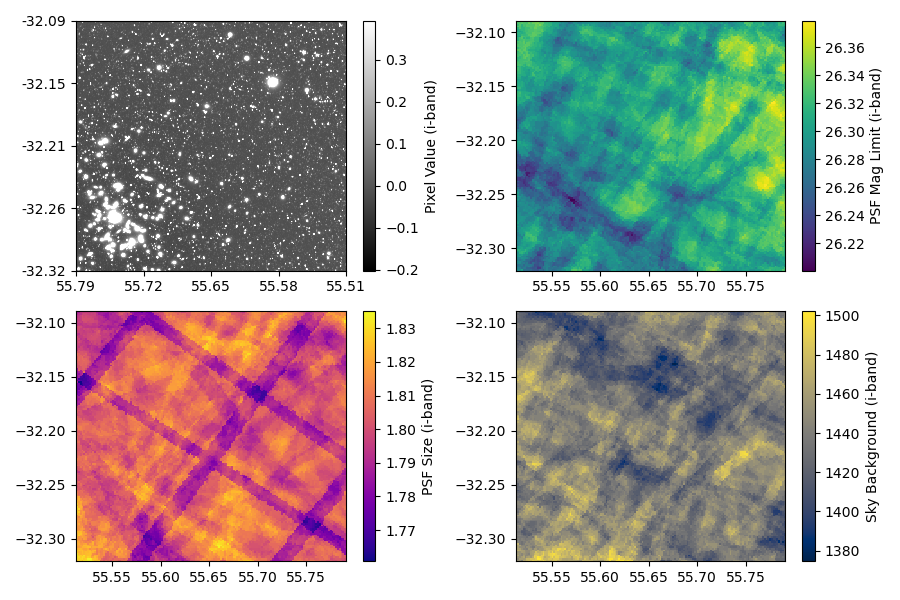

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(9,6))

temp = deepCoadd.image.array.flatten()
norm = ImageNormalize(temp, interval=ZScaleInterval(), stretch=LinearStretch())
im = ax[0,0].imshow(deepCoadd.image.array, cmap='gray', norm=norm,
                    extent=deepCoadd_extent, origin='lower')
fig.colorbar(im, ax=ax[0,0], label="Pixel Value (i-band)")
ax[0,0].set_xticks(xtick_locs, xtick_lbls)
ax[0,0].set_yticks(ytick_locs, ytick_lbls)
ax[0,0].axis('tight')

values = hspmap.get_values_pos(x,y)
pcm = ax[0,1].pcolormesh(x, y, values, cmap='viridis')
fig.colorbar(pcm, ax=ax[0,1], label="PSF Mag Limit (i-band)")
ax[0,1].axis('tight')
del pcm, values

values = hspmap_psf.get_values_pos(x,y)
pcm = ax[1,0].pcolormesh(x, y, values, cmap='plasma')
fig.colorbar(pcm, ax=ax[1,0], label="PSF Size (i-band)")
ax[1,0].axis('tight')
del pcm, values

values = hspmap_sky.get_values_pos(x,y)
pcm = ax[1,1].pcolormesh(x, y, values, cmap='cividis')
fig.colorbar(pcm, ax=ax[1,1], label="Sky Background (i-band)")
ax[1,1].axis('tight')
del pcm, values

plt.tight_layout()

del fig, ax, temp, norm